# Descriptions

## In this kernel I share the code to make mask which can directly regress the place of each car, 
## By using this code you can directly regress values of yaw, pitch, roll, x, y, z from the exact place of the car, and also get more precise place of the car than centernet.

# Why I share this idea?

## it's because I'm also doing GoogleQA competition, I'm thinking to make effort to that competition, then I cannot contribute to this competition anymore, but I really wanted to test if this idea works, then I want some others to use this idea in this competition.
## I hope this idea works

# Settings & Mathmatics

## I found points of the PredictionString are sorted based on the distance of the car, then What I did for making segmentation mask was plotted mask from the farest car& padded 0 for the contour of each cars (when finding contours I found morphological transformantions)

In [1]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


import matplotlib.pyplot as plt
from math import sin, cos
import pandas as pd
import numpy as np
import json
import cv2
import os
from math import sin, cos

PATH = '../input/pku-autonomous-driving/'
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)
IMG_SHAPE = (2710, 3384, 3)

# map 3d bounding box into 2d
cars = [
        'baojun-310-2017','biaozhi-3008','biaozhi-liangxiang','bieke-yinglang-XT',
        'biyadi-2x-F0','changanbenben','dongfeng-DS5','feiyate',
        'fengtian-liangxiang','fengtian-MPV','jilixiongmao-2015','lingmu-aotuo-2009',
        'lingmu-swift','lingmu-SX4-2012','sikeda-jingrui','fengtian-weichi-2006',
        '037-CAR02','aodi-a6','baoma-330','baoma-530',
        'baoshijie-paoche','bentian-fengfan','biaozhi-408','biaozhi-508',
        'bieke-kaiyue','fute','haima-3','kaidilake-CTS',
        'leikesasi','mazida-6-2015','MG-GT-2015','oubao',
        'qiya','rongwei-750','supai-2016','xiandai-suonata',
        'yiqi-benteng-b50','bieke','biyadi-F3','biyadi-qin',
        'dazhong','dazhongmaiteng','dihao-EV','dongfeng-xuetielong-C6',
        'dongnan-V3-lingyue-2011','dongfeng-yulong-naruijie','019-SUV','036-CAR01',
        'aodi-Q7-SUV','baojun-510','baoma-X5','baoshijie-kayan',
        'beiqi-huansu-H3','benchi-GLK-300','benchi-ML500','fengtian-puladuo-06',
        'fengtian-SUV-gai','guangqi-chuanqi-GS4-2015','jianghuai-ruifeng-S3','jili-boyue',
        'jipu-3','linken-SUV','lufeng-X8','qirui-ruihu',
        'rongwei-RX5','sanling-oulande','sikeda-SUV','Skoda_Fabia-2011',
        'xiandai-i25-2016','yingfeinidi-qx80','yingfeinidi-SUV','benchi-SUR',
        'biyadi-tang','changan-CS35-2012','changan-cs5','changcheng-H6-2016',
        'dazhong-SUV','dongfeng-fengguang-S560','dongfeng-fengxing-SX6'
        ]
cid2name = {}
for i in range(len(cars)):
    cid2name[i] = cars[i]
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x
def get_img_coords(s):
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2]
    return img_xs, img_ys
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))
def draw_obj(image, vertices, triangles, num_for_color):
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
#         cv2.fillConvexPoly(image, coord, (0,0,255))
        place = num_for_color%3
        color = [0,0,0]
        color[place] = 255
        color = tuple(color)
        cv2.polylines(image, np.int32([coord]), 1, color)
    return image
def draw_bw(image, vertices, triangles, num_for_color):
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
        color = [255,255,255]
        color = tuple(color)
        cv2.polylines(image, np.int32([coord]), 1, color)
    return image
def visualize(img, coords):
    img = img.copy()
    num_for_color = 0
    masks = np.zeros(8*img.shape[0]*img.shape[1]).reshape(8, img.shape[0], img.shape[1])
    for point in coords:
        c_model = cid2name[int(point['id'])] + '.json'
        with open(PATH+'car_models_json/'+c_model) as json_file:
            data = json.load(json_file)
        vertices = np.array(data['vertices'])
        vertices[:, 1] = -vertices[:, 1]
        triangles = np.array(data['faces']) - 1
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.ones((vertices.shape[0],vertices.shape[1]+1))
        P[:, :-1] = vertices
        P = P.T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # find counters
        overlay = np.zeros_like(img)
        overlay = draw_bw(overlay, img_cor_points, triangles, num_for_color)
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2GRAY)
        contours, hierarchy = cv2.findContours(overlay, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        # draw counters
        for i in range(len(contours)):
            if hierarchy[0][i][3]==-1:
                overlay = cv2.drawContours(overlay, contours, i, 255, -1)
        # for instance segmentation
        overlay_contours = overlay
        overlay_contours = cv2.Canny(overlay_contours, 30, 200)
        kernel = np.ones((8,8),np.uint8)
        overlay_contours = cv2.dilate(overlay_contours,kernel,iterations = 1)
        # logits
        masks[0][overlay!=0] = 1
        # for IS
        masks[0][overlay_contours!=0] = 0
        # x
        masks[1][overlay!=0] = point['x']/100
        # y
        masks[2][overlay!=0] = point['y']/100
        # z
        masks[3][overlay!=0] = point['z']/100
        # yaw
        masks[4][overlay!=0] = point['yaw']
        # pitch sin
        psin = sin(point['pitch'])
        masks[5][overlay!=0] = psin
        # pitch cos
        pcos = cos(point['pitch'])
        masks[6][overlay!=0] = pcos
        # roll
        masks[7][overlay!=0] = rotate(point['roll'],np.pi)
        
        #plt.imshow(overlay)
        #plt.show()
        img = draw_obj(img, img_cor_points, triangles, num_for_color)
        num_for_color += 1
    return img, masks

cuda


# Dataset (returns preprocessed image, mask of ignorant car place, regr)

In [2]:
from torch.utils.data import Dataset, DataLoader

scale = 2

class CData(Dataset):
    def __init__(self, dataframe, img_dir, mask_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.training = training
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        coord_for_trick = [str2coords(self.df['PredictionString'].iloc[idx])[-(i+1)] for i in range(len(str2coords(self.df['PredictionString'].iloc[idx])))]
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        mask_name = self.mask_dir.format(idx)
        # Read image (size (2710, 3384, 3))
        img = imread(img_name, True)
        # Make regr (size (7, 2710, 3384))
        _, regr = visualize(img, coord_for_trick)
        # Resize image into (size (3, 2710, 3384))
        img = img[1430:, :, :]
        img = cv2.resize(img, (3072//scale, 1280//scale))
        img = np.rollaxis(img, 2, 0)
        # (7, 2710, 3384) -> (1280, 3384, 7)
        regr = regr[:, 1430:, :]
        regr = np.rollaxis(np.rollaxis(regr, 2, 0), 2, 0)
        # (1280, 3384, 7) -> (7, 1280, 3072)
        regr = cv2.resize(regr, (3072//scale, 1280//scale))
        regr = np.rollaxis(regr, 2, 0)
        # Get mask and regression maps (size (3, 2710, 3384))
        mask = imread(mask_name, True)
        if type(mask)==np.ndarray:
            mask = mask[1430:, :, :]
            mask = cv2.resize(mask, (3072//scale, 1280//scale))
            mask = np.rollaxis(mask, 2, 0)
        if type(mask)!=np.ndarray:
            mask = np.zeros(2710*3384*3).reshape(2710,3384,3)
            mask = mask[1430:, :, :]
            mask = cv2.resize(mask, (3072//scale, 1280//scale))
            mask = np.rollaxis(mask, 2, 0)
        # Cut (2710, 3384) -> (1280, 3384) -> Resize -> (1280, 3072)
        
        # To Tensor
        img = torch.tensor(img, device=device).float()/255
        mask = torch.tensor(mask, device=device).float()/255
        regr = torch.tensor(regr, device=device).float()
        
        return [img, mask, regr]

# DataLoader

In [3]:
BATCH_SIZE = 4


from sklearn.model_selection import train_test_split

train_images_dir = PATH + 'train_images/{}.jpg'
train_masks_dir = PATH + 'train_masks/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'
test_masks_dir = PATH + 'test_masks/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.1, random_state=42)
df_test = test


train_dataset = CData(df_train, train_images_dir, train_masks_dir, training=True)
dev_dataset = CData(df_dev, train_images_dir, train_masks_dir, training=False)
test_dataset = CData(df_test, test_images_dir, test_masks_dir, training=False)


train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Example of the regr

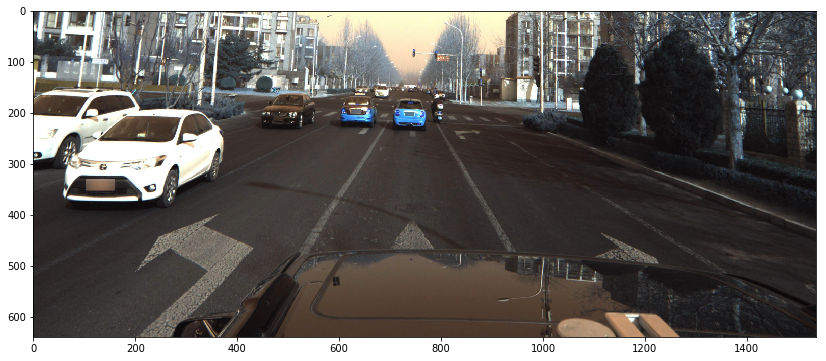

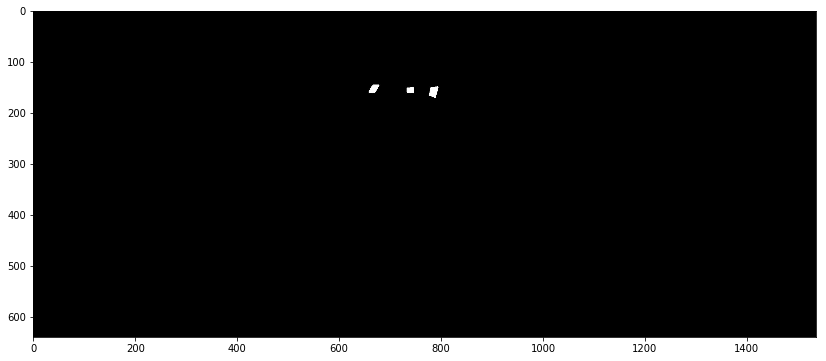

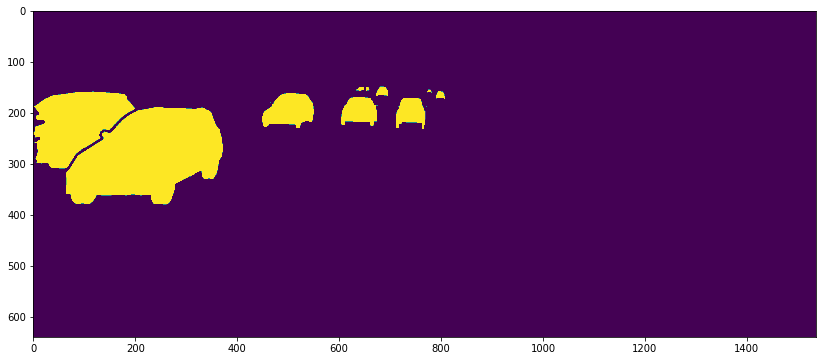

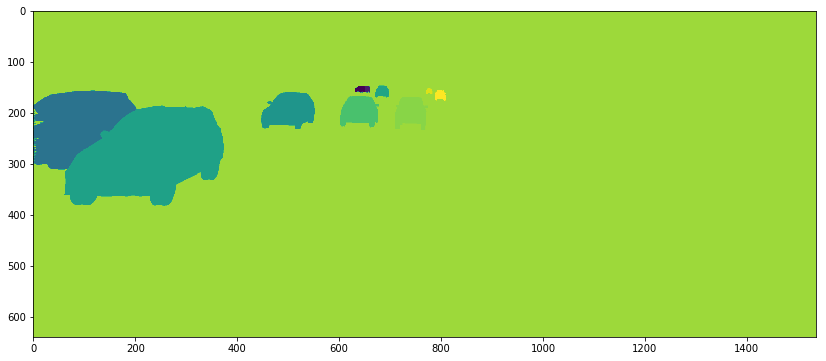

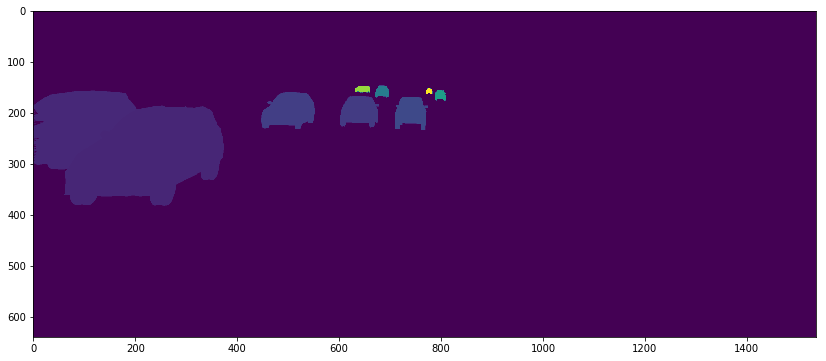

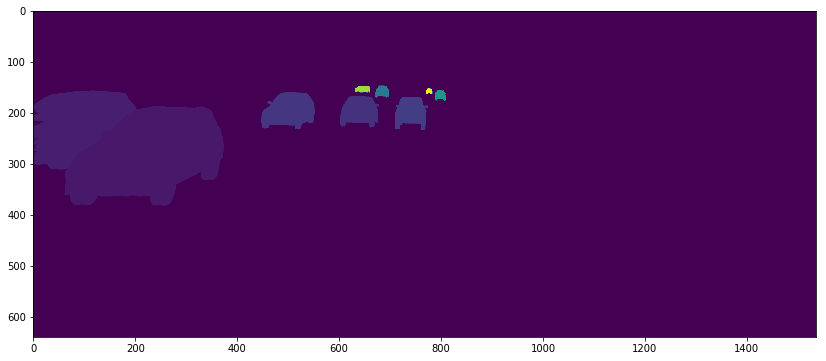

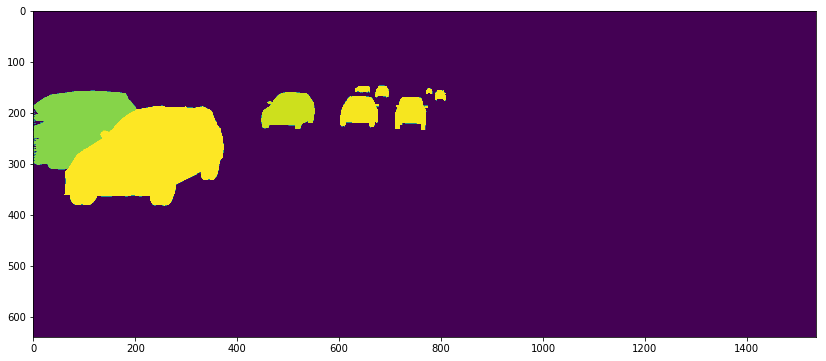

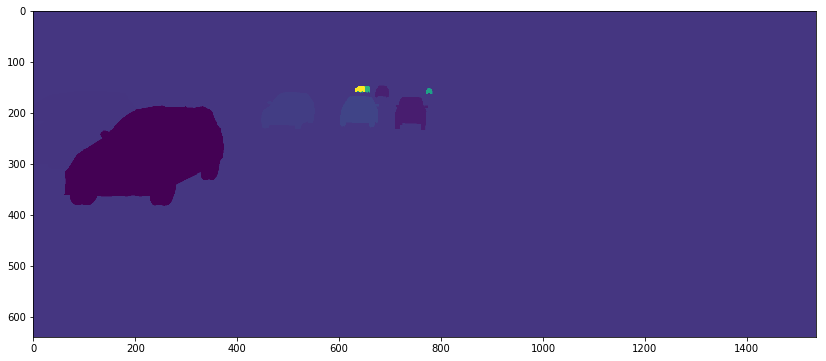

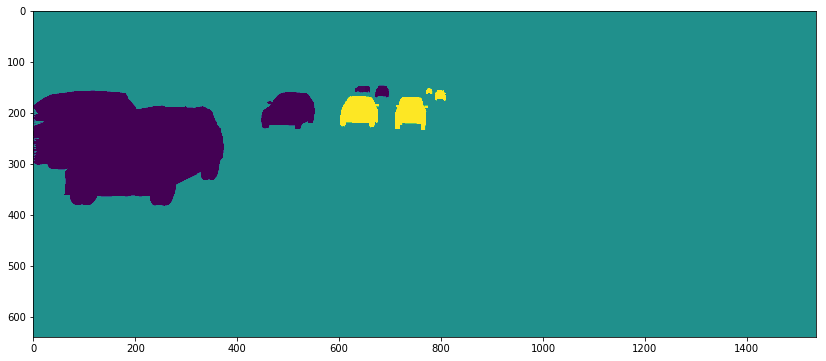

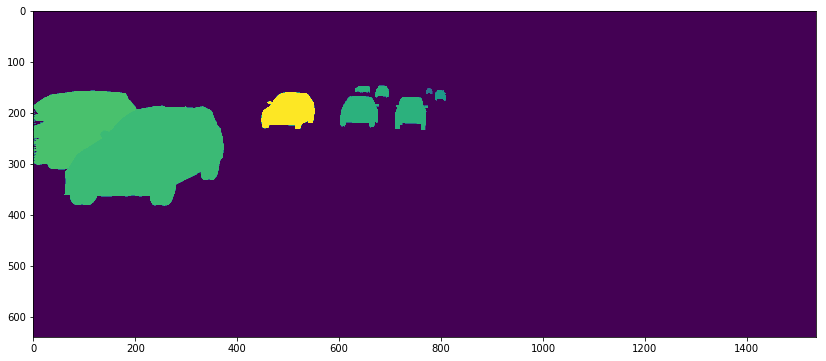

In [4]:
a, b, c = train_dataset[0]
plt.figure(figsize=(18, 6))
plt.imshow(np.rollaxis(np.rollaxis(a.detach().cpu().numpy(),2,0),2,0))
plt.show()
plt.figure(figsize=(18, 6))
plt.imshow(np.rollaxis(np.rollaxis(b.detach().cpu().numpy(),2,0),2,0))
plt.show()
for i in range(8):
    plt.figure(figsize=(18, 6))
    plt.imshow(c.detach().cpu().numpy()[i])
    plt.show()

# Model (This time Simple Unet, resnext based mask rcnn can be the best)

In [5]:

import torch.nn as nn

class double_conv(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    
    def __init__(self, n_classes):
        
        super(UNet, self).__init__()
        
        self.dc0 = double_conv(3, 32)
        self.mp0 = nn.MaxPool2d(2)
        self.dc1 = double_conv(32, 64)
        self.mp1 = nn.MaxPool2d(2)
        self.dc2 = double_conv(64, 128)
        self.mp2 = nn.MaxPool2d(2)
        self.dc3 = double_conv(128, 256)
        self.mp3 = nn.MaxPool2d(2)
        self.dc4 = double_conv(256, 256)
        self.up0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dc5 = double_conv(512, 128)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dc6 = double_conv(256, 64)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dc7 = double_conv(128, 32)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        
        x0 = self.dc0(x)
        x1 = self.dc1(self.mp0(x0))
        x2 = self.dc2(self.mp1(x1))
        x3 = self.dc3(self.mp2(x2))
        x = self.dc4(self.mp3(x3))
        x = torch.cat([x3, self.up0(x)],1)
        x = self.up1(self.dc5(x))
        x = torch.cat([x2, x],1)
        x = self.up2(self.dc6(x))
        x = torch.cat([x1, x],1)
        x = self.up3(self.dc7(x))
        x = torch.cat([x0, x],1)
        x = self.last(x)
        
        return x
    
def criterion(prediction, mask, regr, size_average=True):
    
    pred_mask = torch.sigmoid(prediction[:, 0])
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    
    loss = mask_loss + regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss


def train_model(epoch):
    model.train()

    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):

        img_batch = img_batch.to(device).float()
        mask_batch = mask_batch.to(device).float()
        regr_batch = regr_batch.to(device).float()

        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, regr_batch[:,0], regr_batch[:,1:])
        loss.backward()

        optimizer.step()
        
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))
    
def evaluate_model(epoch):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device).float()
            mask_batch = mask_batch.to(device).float()
            regr_batch = regr_batch.to(device).float()

            output = model(img_batch)

            loss += criterion(output, regr_batch[:,0], regr_batch[:,1:], size_average=False).data
    
    loss /= len(dev_loader.dataset)
    print('Dev loss: {:.4f}'.format(loss))
    
    return loss

# Training

In [6]:
import gc
import torch.optim as optim
from tqdm import tqdm


n_epochs = 30
model = UNet(8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
'''
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch)
    dev_loss = evaluate_model(epoch)
    if epoch == 0:
        best_loss = dev_loss
    else:
        if dev_loss <= best_loss:
            best_loss = dev_loss
            torch.save(model.state_dict(), './is_unet_v2.pth')
            print('saved best model')
'''
'remove comment out if training'

'remove comment out if training'

# Pred/ Make Sub

## What I'm doing is
### 1st : thresholding at possibility 0.7 
### 2nd : by using morphological transformation & findcontours I got the gravity points(gY, gX) of each predicted cars, and the values of image[:,gY,gX] will be the prediction

In [7]:
'''

from tqdm import tqdm

model = UNet(8).to(device)
model.load_state_dict(torch.load('./is_unet_v2.pth'))

model.eval()
loss = 0
th = 0.7

with torch.no_grad():
    
    cc = 0
    
    for idx, (a, b, c) in enumerate(test_loader):
        

        a = a.to(device).float()
        b = b.to(device).float()
        c = c.to(device).float()

        out0 = model(a.view(1,3,640,1530))
        ad = a.detach().cpu().numpy()
        od0 = torch.nn.Sigmoid()(out0[0,0]).detach().cpu().numpy()
        od1 = c[0].detach().cpu().numpy()
        b = cv2.cvtColor(np.rollaxis(np.rollaxis(b[0].detach().cpu().numpy(),2,0),2,0), cv2.COLOR_BGR2GRAY)

        od2 = od0
        od2[od0>th] = 1
        od2[b==1] = 0
        od2dash = np.zeros_like(od2)
        od2dash[od2==1] = 1
        od2 = od2dash

        odx = out0[0,1:].detach().cpu().numpy()


        # opening
        # overlay = cv2.morphologyEx(overlay, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))

        # find counters
        overlay = cv2.convertScaleAbs(od2)
        contours, hierarchy = cv2.findContours(overlay, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        # draw counters
        for i in range(len(contours)):
            if hierarchy[0][i][3]==-1:
                overlay = cv2.drawContours(overlay, contours, i, 255, -1)

        overlay2 = np.zeros_like(overlay)

        sub_points = []

        count_last = 0
        for i, c in enumerate(contours):
            unum = 0
            for one in np.unique(contours[i][:,:,0]):
                unum += len(np.unique(contours[i][:,:,0][contours[i][:,:,0]==one]))
            if unum >= 6:
                param = []
                # calculate moments for each contour
                M = cv2.moments(c)

                if M["m00"] != 0:

                    # calculate x,y coordinate of center
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    #cv2.circle(overlay2, (cX, cY), 5, (255, 255, 255), -1)

                    # make sub
                    # x
                    param.append(odx[0,cY,cX]*100)
                    # y
                    param.append(odx[1,cY,cX]*100)
                    # z
                    param.append(odx[2,cY,cX]*100)
                    # yaw
                    param.append(odx[3,cY,cX])
                    # pitch
                    pitch_sin = odx[4,cY,cX] / np.sqrt(odx[4,cY,cX]**2 + odx[4,cY,cX]**2)
                    pitch_cos = odx[5,cY,cX] / np.sqrt(odx[5,cY,cX]**2 + odx[5,cY,cX]**2)
                    param.append(np.arccos(pitch_cos) * np.sign(pitch_sin))
                    # roll
                    param.append(rotate(odx[6,cY,cX], -np.pi))
                    # logit == 1 (this time)
                    param.append(1)

                    sub_points.append(param)
                    count_last += 1

        print(count_last)

        lastsub = ''

        for points in sub_points:
            for p in points:
                lastsub += ' ' + str(p)

        lastsub = lastsub[1:]

        test['PredictionString'][cc] = lastsub

        cc += 1
            
'''
'this code can have something wrong'

'this code can have something wrong'

In [8]:
#test.to_csv('submission.csv', index=False)